In [1]:
import parse
import numpy as np
import math
import matplotlib.pyplot as plt

from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go


In [2]:
use_plotly = False
filenames = ['poses/bicep_bad_1', 'poses/bicep_bad_2', 'poses/bicep_bad_3', 'poses/bicep_bad_4', 'poses/bicep_bad_5', 'poses/bicep_bad_6', 'poses/bicep_bad_7', 'poses/bicep_bad_8', 'poses/bicep_bad_9', 'poses/bicep_good_1', 'poses/bicep_good_2', 'poses/bicep_good_3', 'poses/bicep_good_4', 'poses/bicep_good_5', 'poses/bicep_good_6']

# Get all the pose sequences from the parser
# TODO: save these in the future
all_ps = parse.main()

Starting PoseSequence 0
Filename: poses/bicep_bad_1
Primary arm: Right
Range of Angles between Upper Arm and Torso: 35.23131076818897


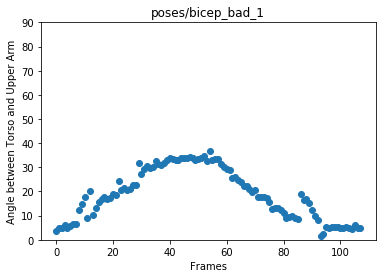

Minimum Angle between Upper Arm and Forearm: 31.89380019853303


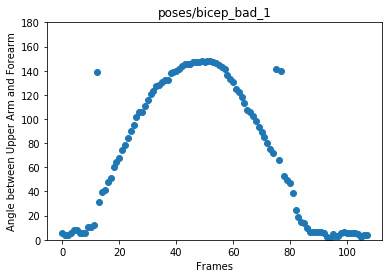

Starting PoseSequence 1
Filename: poses/bicep_bad_2
Primary arm: Right
Range of Angles between Upper Arm and Torso: 51.65628085641167


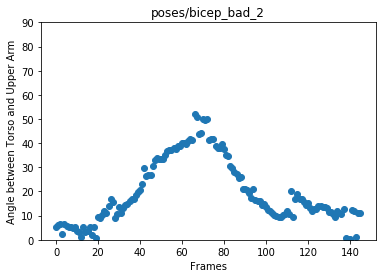

Minimum Angle between Upper Arm and Forearm: 32.94776489071103


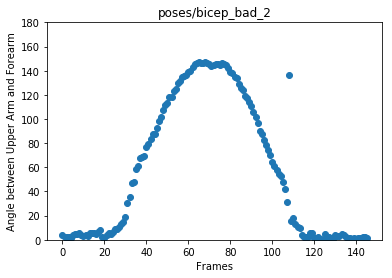

Starting PoseSequence 2
Filename: poses/bicep_bad_3
Primary arm: Right
Range of Angles between Upper Arm and Torso: 12.125247430230303


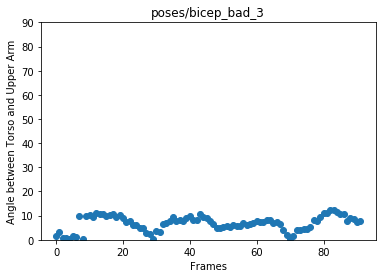

Minimum Angle between Upper Arm and Forearm: 32.03850166883436


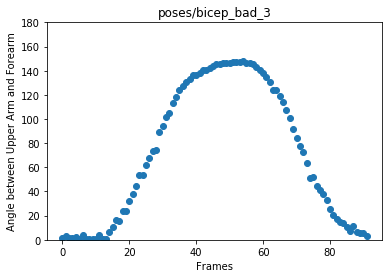

Starting PoseSequence 3
Filename: poses/bicep_bad_4
Primary arm: Right
Range of Angles between Upper Arm and Torso: 13.669769078356863


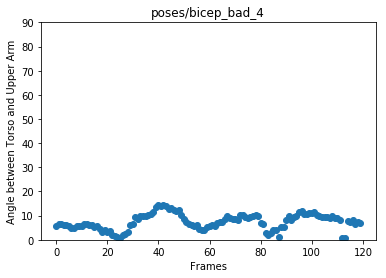

Minimum Angle between Upper Arm and Forearm: 32.12747064266651


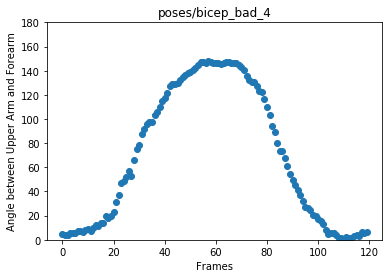

Starting PoseSequence 4
Filename: poses/bicep_bad_5
Primary arm: Right
Range of Angles between Upper Arm and Torso: 47.86090725410961


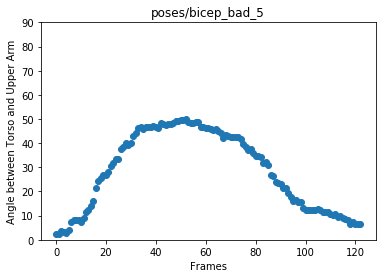

Minimum Angle between Upper Arm and Forearm: 47.46120931443056


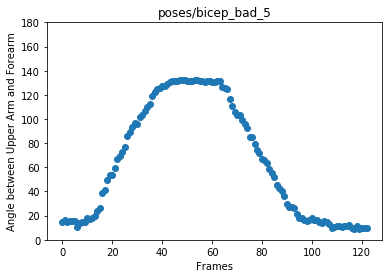

Starting PoseSequence 5
Filename: poses/bicep_bad_6
Primary arm: Right
Range of Angles between Upper Arm and Torso: 66.10067607507816


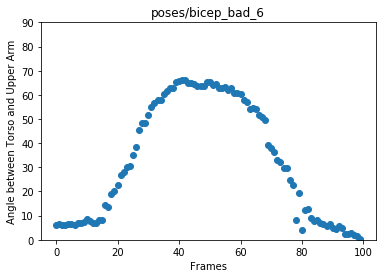

Minimum Angle between Upper Arm and Forearm: 42.57700526684684


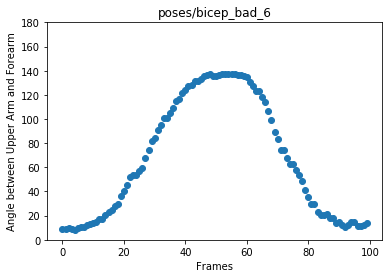

Starting PoseSequence 6
Filename: poses/bicep_bad_7
Primary arm: Right
Range of Angles between Upper Arm and Torso: 48.902573661802236


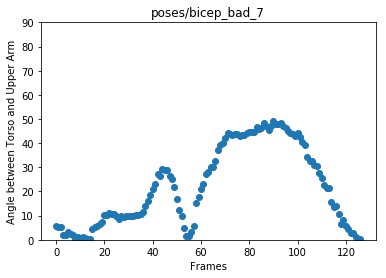

Minimum Angle between Upper Arm and Forearm: 41.56022875358917


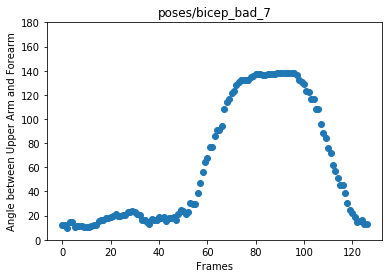

Starting PoseSequence 7
Filename: poses/bicep_bad_8
Primary arm: Left
Range of Angles between Upper Arm and Torso: 18.266174769558557


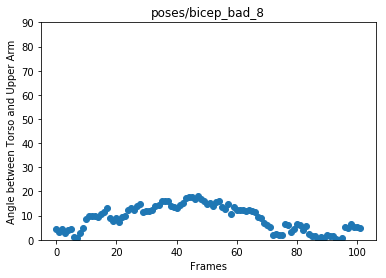

Minimum Angle between Upper Arm and Forearm: 35.55319854541415


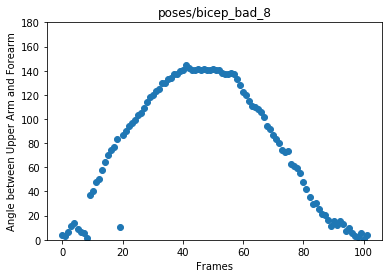

Starting PoseSequence 8
Filename: poses/bicep_bad_9
Primary arm: Left
Range of Angles between Upper Arm and Torso: 21.706423481005686


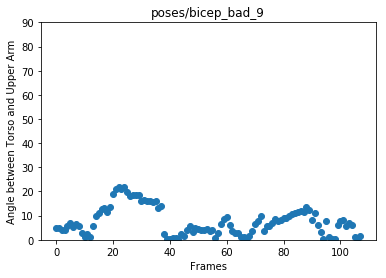

Minimum Angle between Upper Arm and Forearm: 33.392575280372654


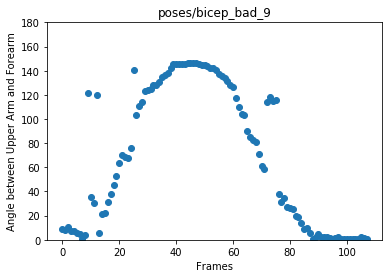

Starting PoseSequence 9
Filename: poses/bicep_good_1
Primary arm: Right
Range of Angles between Upper Arm and Torso: 21.150955500327434


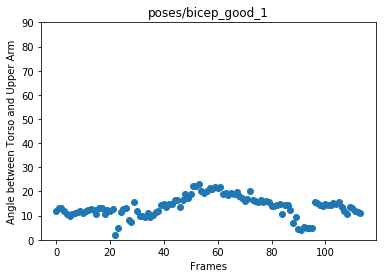

Minimum Angle between Upper Arm and Forearm: 40.74447650965104


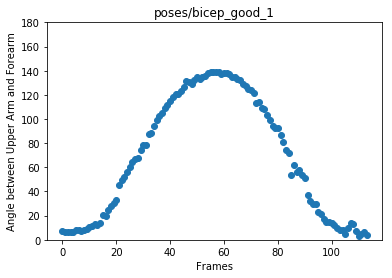

Starting PoseSequence 10
Filename: poses/bicep_good_2
Primary arm: Right
Range of Angles between Upper Arm and Torso: 19.514324857940657


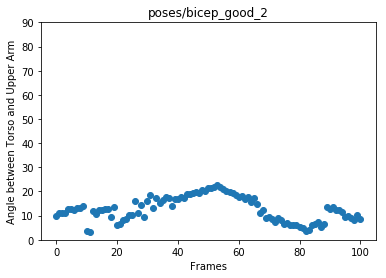

Minimum Angle between Upper Arm and Forearm: 41.370434167685204


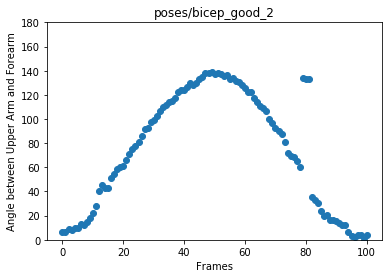

Starting PoseSequence 11
Filename: poses/bicep_good_3
Primary arm: Right
Range of Angles between Upper Arm and Torso: 13.781634499980157


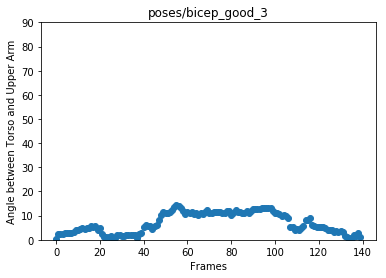

Minimum Angle between Upper Arm and Forearm: 53.5381744764948


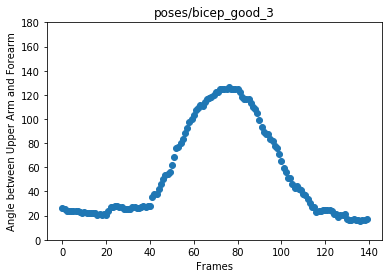

Starting PoseSequence 12
Filename: poses/bicep_good_4
Primary arm: Right
Range of Angles between Upper Arm and Torso: 8.269394105910706


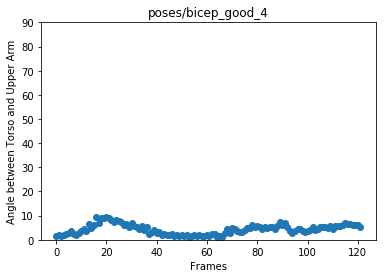

Minimum Angle between Upper Arm and Forearm: 53.03581496154234


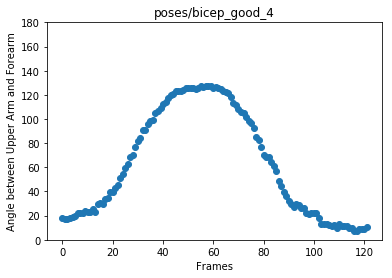

Starting PoseSequence 13
Filename: poses/bicep_good_5
Primary arm: Left
Range of Angles between Upper Arm and Torso: 10.870107436546887


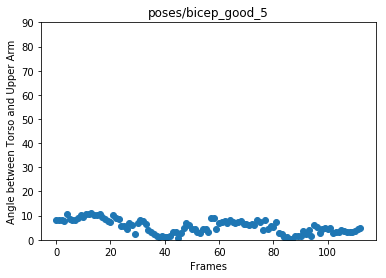

Minimum Angle between Upper Arm and Forearm: 45.596572325840384


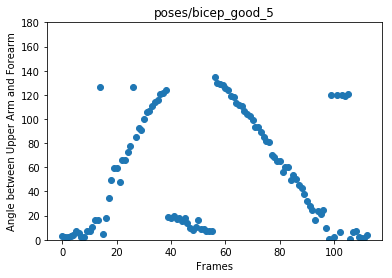

Starting PoseSequence 14
Filename: poses/bicep_good_6
Primary arm: Left
Range of Angles between Upper Arm and Torso: 11.140242134876958


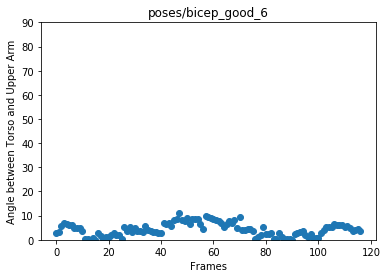

Minimum Angle between Upper Arm and Forearm: 43.60149257299915


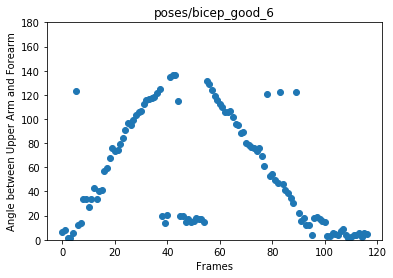

In [3]:
for i, ps in enumerate(all_ps):
    print("Starting PoseSequence {}".format(str(i)))
    print("Filename: {}".format(filenames[i]))
    # Given a PS, we first want to identify which arm is in the viewpoint
    # For every pose in the PS, count the number of times 
    # shoulder/elbow/wrist is 0 for both left and right side.

    # Count number of non-zeros in right and left
    right_ct, left_ct = 0, 0

    for pose in ps.poses:
        right_loc = [pose.rshoulder, pose.relbow, pose.rwrist]
        left_loc = [pose.lshoulder, pose.lelbow, pose.lwrist]
        for loc in right_loc:
            right_ct = right_ct + 1 if loc.x > 0 else right_ct
            right_ct = right_ct + 1 if loc.y > 0 else right_ct
        for loc in left_loc:
            left_ct = left_ct + 1 if loc.x > 0 else left_ct
            left_ct = left_ct + 1 if loc.y > 0 else left_ct

    # Check which side has less 0's. Deal with tiebreaking later
    side = "Right" if right_ct > left_ct else "Left"
    print("Primary arm: {}".format(side))

    # Things we want to compute:
    # Vector of the upper arm (shoulder -> elbow)
    # Vector of the torso (neck -> hip)
    # Angle between upper arm and torso vector
    #    Upper arm should be parallel to torso throughout the entire vid
    # Vector of the forearm (elbow -> wrist)
    # Angle between forearm and upper arm vector
    #    Original thought: we want the min angle between forearm and upper arm
    #    If angle is too large, that means they didn't go all the way up
    #    Updated thought: we actually want 180 - max angle because of direction

    upper_arm_vectors = []
    torso_vectors = []
    upper_arm_torso_angle = []
    forearm_vectors = []
    upper_forearm_angle = []

    for pose in ps.poses:
        if side == "Right":
            joints = [pose.rshoulder, pose.relbow, pose.rwrist, pose.rhip]
        else:
            joints = [pose.lshoulder, pose.lelbow, pose.lwrist, pose.lhip]

        # Shoulder to elbow (upper arm)
        up_arm_vec = [joints[0].x - joints[1].x, joints[0].y - joints[1].y]
        upper_arm_vectors.append(up_arm_vec)

        # Neck to hip (torso)
        tor_vec = [pose.neck.x - joints[3].x, pose.neck.y - joints[3].y]
        torso_vectors.append(tor_vec)

        # Angle between upper arm and torso
        # Normalize to unit vectors
        up_arm_vec = up_arm_vec / np.linalg.norm(up_arm_vec)
        tor_vec = tor_vec / np.linalg.norm(tor_vec)
        # Calculate angle between two vectors
        angle = math.degrees(np.arccos(np.clip(np.dot(up_arm_vec, tor_vec), -1.0, 1.0)))
        upper_arm_torso_angle.append(angle)
        
        # Elbow to wrist (forearm)
        forearm_vec = [joints[1].x - joints[2].x, joints[1].y - joints[2].y]
        forearm_vectors.append(forearm_vec)
        
        # Angle between upper arm and forearm
        forearm_vec = forearm_vec / np.linalg.norm(forearm_vec)
        angle = math.degrees(np.arccos(np.clip(np.dot(up_arm_vec, forearm_vec), -1.0, 1.0)))
        upper_forearm_angle.append(angle)
        
    
    # Convert to NP arrays for vector ops
    upper_arm_vectors = np.array(upper_arm_vectors)
    torso_vectors = np.array(torso_vectors)
    upper_arm_torso_angle = np.array(upper_arm_torso_angle)
    upper_forearm_angle = np.array(upper_forearm_angle)
    
    # Basically the amplitude of the first plot
    print("Range of Angles between Upper Arm and Torso: {}".format(np.max(upper_arm_torso_angle)-np.min(upper_arm_torso_angle)))
    
    # Generate plots
    if use_plotly:
        trace = go.Scatter(x = np.arange(upper_arm_torso_angle.shape[0]), y = upper_arm_torso_angle, mode = 'markers')
        layout= go.Layout(
            title= filenames[i],
            hovermode= 'closest',
            xaxis= dict(title= 'Frames'),
            yaxis=dict(title= 'Angle between Torso and Upper Arm'),
            showlegend= False
        )
        fig = go.Figure(data=[trace], layout=layout)
        py.iplot(fig, filename='CS_231a_Pose_Trainer/PS{}_{}'.format(i,1))
    else:
        plt.scatter(np.arange(upper_arm_torso_angle.shape[0]),upper_arm_torso_angle)
        plt.title(filenames[i])
        plt.xlabel('Frames')
        plt.ylabel('Angle between Torso and Upper Arm')
        # Set range on y-axis so the plots are consistent
        plt.ylim(0,90) 
        plt.show()
    
    
    # The minimum angle between these two, i.e. if user moved all the way up
    print("Minimum Angle between Upper Arm and Forearm: {}".format(180-np.max(upper_forearm_angle)))
    
    if use_plotly:
        trace = go.Scatter(x = np.arange(upper_arm_torso_angle.shape[0]), y = upper_forearm_angle, mode = 'markers')
        layout= go.Layout(
            title= filenames[i],
            hovermode= 'closest',
            xaxis= dict(title= 'Frames'),
            yaxis=dict(title= 'Angle between Upper Arm and Forearm'),
            showlegend= False
        )
        fig = go.Figure(data=[trace], layout=layout)
        py.iplot(fig, filename='CS_231a_Pose_Trainer/PS{}_{}'.format(i,2))
    else:
        plt.scatter(np.arange(upper_arm_torso_angle.shape[0]),upper_forearm_angle)
        plt.title(filenames[i])
        plt.xlabel('Frames')
        plt.ylabel('Angle between Upper Arm and Forearm')
        # Set range on y-axis so the plots are consistent
        plt.ylim(0,180) 
        plt.show()
    print("="*40)